In [2]:
import alpaca_trade_api as alpaca
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from pandas.plotting import lag_plot 
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
sns.set(font_scale= .7)
from pylab import rcParams

In [4]:
alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')
# Set the ticker symbol and time frame
ticker = ["AAPL", "MSFT","GOOG","INTC","NVDA"]
timeframe = "1Day"
start_date = "2016-01-01T00:00:00-00:00"
end_date = "2024-01-01T00:00:00-00:00"

# Retrieve the data
portfolio = pd.DataFrame(alpaca_api.get_bars(ticker, timeframe, start_date, end_date).df)

In [5]:
portfolio.tail()

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2023-12-22 05:00:00+00:00,488.30,493.8300,484.67,382488,491.95,25228960,489.787961,NVDA
2023-12-26 05:00:00+00:00,492.79,496.0000,489.60,353363,489.68,24422298,493.568192,NVDA
2023-12-27 05:00:00+00:00,494.17,496.8000,490.85,337162,495.11,23369993,493.586869,NVDA
2023-12-28 05:00:00+00:00,495.22,498.8399,494.12,371424,496.43,24660983,496.423354,NVDA
2023-12-29 05:00:00+00:00,495.22,499.9700,487.51,519870,498.13,38881377,495.199392,NVDA


In [4]:
fig = px.line(portfolio, x=portfolio.index, 
              y='close', 
              color='symbol', 
              title="Stock Market Performance")
fig.show()

In [ ]:
plt.figure()
lag_plot(aapl.close, lag=2)
plt.title('TESLA Stock - Autocorrelation plot with lag = 2')
plt.show()

ValueError: cannot reindex on an axis with duplicate labels

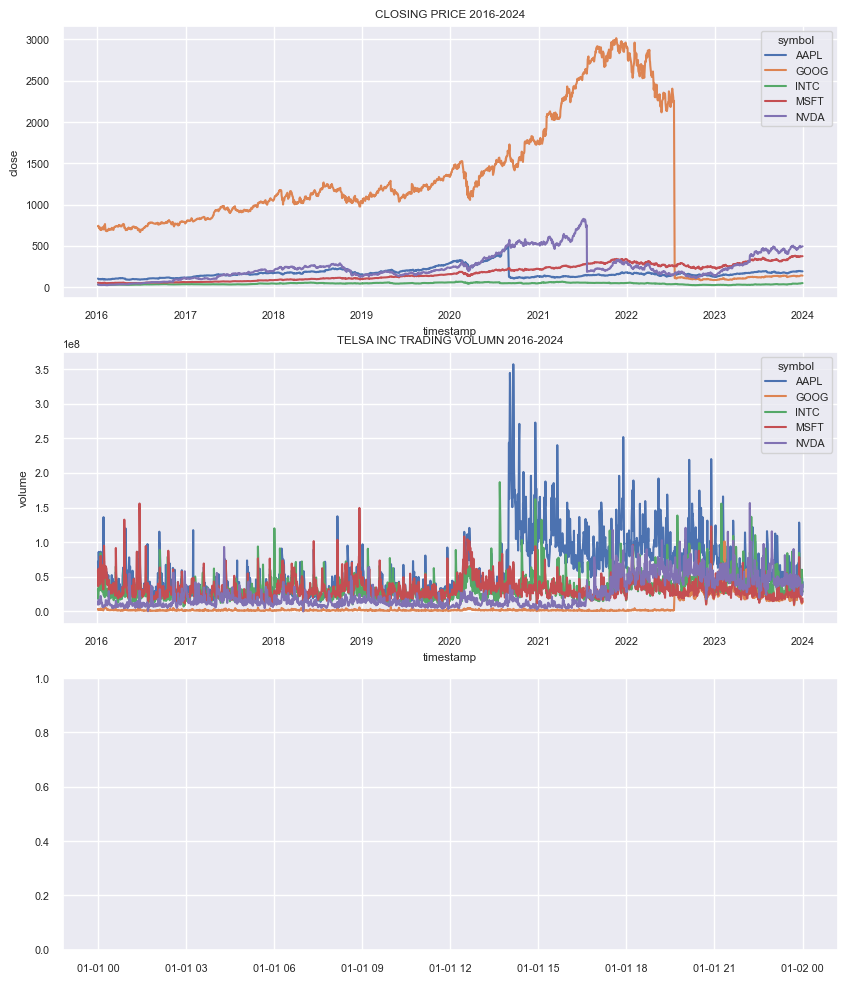

In [7]:
# visualize the data
plt.rcParams['font.size'] = 8
fig, axes = plt.subplots(3,1,figsize=(10,12))
sns.lineplot(x=portfolio.index,y=portfolio.close, hue= portfolio.symbol, ax=axes[0]).set_title('CLOSING PRICE 2016-2024')
#axes[0].set_ylabel("Daily closing stock price")
#high = portfolio['close'].max()
#dateHigh= portfolio[portfolio['close'] == high].index
#axes[0].annotate(f"All time high price during\n8 year period\nwas ${high} on {dateHigh.strftime('%Y-%m-%d,%r').values}", 
                #  xy=(dateHigh,high),xytext=(dateHigh+pd.DateOffset(days=100)  ,high-100),
                # bbox=dict(boxstyle="round",facecolor='#C2CD23', edgecolor='#d0d5db'),
                #  arrowprops=dict(facecolor="#918BC3",headlength=10, shrink=0.1))
sns.lineplot(x=portfolio.index,y=portfolio.volume,hue= portfolio.symbol,  ax=axes[1], color='purple').set_title('TELSA INC TRADING VOLUMN 2016-2024')
highVal = portfolio['volume'].max()
# dateHighVal= portfolio[portfolio['volume'] == highVal].index
# axes[1].annotate(f"All time high trading volumn during\n8 year period\nwas {highVal:,} on {dateHighVal.strftime('%Y-%m-%d,%r').values}", 
#                  xy=(dateHighVal,highVal),xytext=(dateHighVal+pd.DateOffset(days=100)  ,highVal-9**8),
#                 bbox=dict(boxstyle="round",facecolor='#C2CD23', edgecolor='#d0d5db'),
#                  arrowprops=dict(facecolor="#918BC3",headlength=10, shrink=0.1))
# axes[1].axhline(y=portfolio['volume'].mean(), linestyle='--',lw=1, color='yellow')
# axes[1].annotate(f"Average trade volume {round(portfolio['volume'].mean(),2):,}", 
#                 xy=(portfolio.index.mean(),portfolio.volume.mean()),xytext=(portfolio.index.mean(),portfolio.volume.mean()),
#                 bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
#                  )

sns.lineplot(x=portfolio.index, y=portfolio.close.pct_change(fill_method='bfill'), hue= portfolio.symbol, label='Daily Percentage Change',ax=axes[2])

# #monthly percent change of stock closing price based on the last day of each month 
# monthR= portfolio.resample('BM').apply(lambda x:x[-1])
# #highValM= monthR.close.pct_change(fill_method='bfill').abs().max()
# #dateHighValM= monthR[monthR['close'].pct_change()== highValM].index
# sns.lineplot(x=monthR.index, y=monthR.close.pct_change(fill_method='bfill'), label='Monthly Percentage Change',ax=axes[2], color='pink')
# #axes[2].annotate(f"All time highest percentage change during\n8 year period\nwas {highValM:,} on {dateHighValM.strftime('%Y-%m-%d,%r').values}", 
# #                xy=(dateHighValM,highValM),xytext=(dateHighValM+pd.DateOffset(days=100) ,highValM-5),
# #                bbox=dict(boxstyle="round",facecolor='#C2CD23', edgecolor='#d0d5db'),
# #                arrowprops=dict(facecolor="#918BC3",headlength=10, shrink=0.1))

plt.show()

In [ ]:
def check_stationarity(series):
    '''Test the null hypothesis of non-stationary time series data,
    if the pvalue is smaller than 0.05 threshold, reject the hypothesis'''
    if len(series) < 10:  # Adjust the threshold as needed
        print("Series is too short to perform ADF test.")
        return None
    
    result = adfuller(series, autolag='AIC', regression='ct')

    print('ADF Statistic: %f' % result[0])
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
    return result
rawClose= check_stationarity(aapl.close)

In [ ]:
def decomposition(closingP, periodList):
    adfR={}
    fig, axes= plt.subplots(nrows=3, ncols=2, figsize=(12,8))
    for row,period in enumerate(periodList):
        modelList=['additive','multiplicative']
        for col, model in enumerate(modelList):
            # decompistion instance
            result_decom = seasonal_decompose(closingP, model=model, 
                                            period=period, extrapolate_trend='freq')
            # plot the componenets 
            result_decom.resid.plot(ax=axes[row,col])
            axes[row, col].set_title(f"{model.capitalize()} Model - Period {period}: Residual Plot")
            plt.tight_layout()
            #trend = result_decom.trend
            #season = result_decom.seasonal
            reside = result_decom.resid
            print(model,period)
            adfResults=check_stationarity(reside)
            adfR[model,period]= adfResults
    plt.show()
    return adfR
#20 trading days per month, and 252 per year
#not much variability in the residuals except for the tear of 2020, while strong seasonality is reflected 
adfPeriod= decomposition(aapl.close, [5,20,252])

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: f'{x:.2e}')
periodStat=pd.concat({k: pd.DataFrame(v).T for k, v in adfPeriod.items()}, axis=0)
periodStat.columns=['adf_statistics','pVal','usedLag','nObs','criticalVal','icbest']
periodStat

In [ ]:
#The best performing model was the multiplicative model with a period set to 20days/month
bestP= seasonal_decompose(aapl.close, model='multiplicative', 
                                            period=20, extrapolate_trend='freq')
fig = plt.figure()
fig = bestP.plot()
plt.suptitle("Best Seasonality- Multiplicative  Model - 20 Days Period")
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

In [ ]:
def test_stationarity(timeseries):

    #Determing rolling statistics - remove noise by taking past 12 months close price 
    #and give a mean value at every point further ahead 
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput )

In [ ]:
#taking log transformation to eliminate the trend 
aapl['logClose']= np.log(aapl.close)
aapl['firstd_close']= aapl.close - aapl.close.shift(1)
aapl['log_firstd_close']= aapl.logClose - aapl.logClose.shift(1)
aapl['log_seasonalD_close']= aapl.logClose - aapl.logClose.shift(periods=20)
aapl['logd_seasonalD_close']= aapl.log_firstd_close - aapl.log_firstd_close.shift(periods=20)
#aapl['20lag_detrend']= aapl.detrend_close- aapl.detrend_close.shift(periods=20)
for col in ['logClose','firstd_close','log_firstd_close','log_seasonalD_close', 'logd_seasonalD_close']:
    print(col)
    test_stationarity(aapl[col].dropna())
    print('\n')

In [ ]:
""" #The best performing model was the multiplicative model with a period set to 20days/month, differencing on that
def detectDiff(timeseries,period ):
    info=[]
    #d=0/1/2
    for i in range(3):
        timeseries.name=f"d{i}_Only"
        info.append(timeseries)
        timeseries=timeseries.diff()
    
    #seasonalD given d=0/1/2
    for i in period:
        for j in range(3):
            timeseries= info[j].diff(periods=i)
            timeseries.name = f"d{j}_SeasonalD{i}"
            info.append(timeseries)
    return pd.DataFrame(info).T
detectD= detectDiff(tsla.logClose,[20])
detectD """

In [ ]:
# overdifferenced since the first lag of acf plot is negatitve, 
# adding and moving averae to the model with order 2, since that is the lag where the acf plot cus off. 
import statsmodels.api as sm
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
plt.suptitle('Log Transformed Close Price w/ 1 Differencing and 1 Seasonal Differencing on Lag 20 vs. w/o Seasonal Differencing', weight='bold')
sm.graphics.tsa.plot_acf(aapl['firstd_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[0][0])
sm.graphics.tsa.plot_pacf(aapl['firstd_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[0][1])

sm.graphics.tsa.plot_acf(aapl['logd_seasonalD_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[1][0])
sm.graphics.tsa.plot_pacf(aapl['logd_seasonalD_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[1][1])

sm.graphics.tsa.plot_acf(aapl['log_firstd_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[2][0])
sm.graphics.tsa.plot_pacf(aapl['log_firstd_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[2][1])

#d1,D1
plt.tight_layout()
plt.show()

In [ ]:
from pmdarima.arima import ndiffs,nsdiffs

kpss_diffs = ndiffs(aapl.close, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(aapl.close, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"Estimated differencing term: {n_diffs}")

ch_Sdiffs = nsdiffs(aapl.close, m=20, test='ch',max_D=6)
print(f"Estimated seasonaldifferencing term: {ch_Sdiffs}")

In [ ]:
#x=aapl.close
train,test=aapl[aapl.index.year<2023],aapl[aapl.index.year>=2023]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train.close, 'green', label='Train data')
plt.plot(test.close, 'blue', label='Test data')
plt.legend()

In [ ]:
train

In [ ]:
train = train[train.columns[:5]]
test = test[test.columns[:5]]
train

In [ ]:
import warnings 
warnings.filterwarnings('ignore')
exogenous_features = ['high', 'low','open' ]
model = sm.tsa.arima.ARIMA(endog=train['close'], exog=train[exogenous_features], order=(1, 1, 1))          #(p,d,q)
model_fit = model.fit()
model_fit.summary()

In [ ]:
train

In [ ]:
import pmdarima as pmd
#Best model:  ARIMA(0,1,0)(3,1,1)[20]  
model_autoARIMA=pmd.auto_arima(train.close,
                               X= train.volume,
                      max_p=5, max_q=5, # maximum p and q
                      m=20,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
fitted= model_autoARIMA.fit(train.close)
print(fitted.summary())
fitted.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
import statsmodels.api as sm
model = ARIMA(train.close, order=(0,1,0), seasonal_order=(2, 1, 0, 20),)
fitted = model.fit()
print(fitted.summary())


In [ ]:
from sklearn.metrics import mean_squared_error
training_data = train['close'].values
test_data = test['close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0), seasonal_order=(2, 1, 0, 20) )
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

In [ ]:
MSE_error

In [ ]:
test_set_range = test.index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
#plt.xticks(np.arange(881,1259,50), aapl.Date[881:1259:50])
plt.legend()
plt.show()

In [ ]:
fc= fitted.predict(n_periods=len(test))

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train.close, label='training data')
plt.plot(test.close, color = 'blue', label='Actual Stock Price')
plt.plot(fc, color = 'orange',label='Predicted Stock Price')

plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
model = sm.tsa.arima.ARIMA(train, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

history = [x for x in train]
predictions = list()

output = fitted.forecast()
yhat = output
predictions.append(yhat)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
test.plot()
predictions.plot(color='red')
plt.show()

In [ ]:
fc, se, conf = fitted.forecast(321, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training data')
plt.plot(test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
model=SARIMAX(endog=tsla.seasonal_first_diff_close.dropna(), 
              order=(0,0,1), seasonal_order=(2,0,0,20), trend='ct').fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [ ]:
model.summary()

In [ ]:
sarimax_model = SARIMAX(endog=tslaDiffL.close.dropna().values, trend='ct',
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [ ]:
print(sarimax_model.summary())

In [ ]:
from statsmodels.tsa.stattools import acf, q_stat
from scipy.stats import probplot, moment
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
plot_correlogram(pd.Series(sarimax_model.resid))

In [ ]:
for index, row in df.iterrows():
    if row["Mid"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["Mid"] < 0:
        df.loc[index,"Signal"] = -1.0

'''for index, row in df.iterrows():
    if row["close"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["close"] < 0:
        df.loc[index,"Signal"] = 0'''
        
'''for index, row in df.iterrows():
    if row["vwap"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["vwap"] < 0:
        df.loc[index,"Signal"] = 0.0'''
        
# Calculate the points in time at which a position should be taken, 1 or -1
#ema_signals_df['Crossover']= ema_signals_df['Signal'].diff()
#ema_signals_df=ema_signals_df.dropna()
#ema_signals_df['Crossover']=ema_signals_df['Crossover'].shift(-8)
df["Signal"]=df["Signal"].shift(-1)
df['FutureSlope']=df["close"].shift(-1)

'''ema_signals_df['Crossover']=ema_signals_df['Signal'].diff()
# Review the DataFrame
#ema_signals_df=ema_signals_df['Crossover'].dropna()
ema_signals_df=ema_signals_df.dropna()'''
df.tail(10)

In [ ]:
#display(df.hvplot.scatter(y='CloseDiff3MA',x='3MASlope'))

lstColumns=df.columns

display(lstColumns)

dfopt=pd.DataFrame()

for column in lstColumns:
    display(df.hvplot.scatter(y='FutureMid',x=column))
    dfopt=df[['FutureMid',column]]
    display(dfopt.corr())

In [ ]:
df=df.dropna()

y = df['Signal']

# Review the value counts
y.value_counts()

In [ ]:
df

In [ ]:
# Select the start of the training period

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

X = df[['10MASlope','2MASlope','CloseDiff3MA']].dropna()




training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(months=48)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

display(X_test_scaled)

In [ ]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC(probability=True) 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


In [ ]:
from sklearn.linear_model import LogisticRegression

logModel = LogisticRegression()

model=logModel.fit(X_train_scaled, y_train)
log_pred=logModel.predict(X_test_scaled)

log_testing_report = classification_report(y_test, log_pred)

print(log_testing_report)


In [ ]:
4991/9151

In [ ]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = svm_pred

predictions_df["actual_returns"] = df["vwap"].shift(-1)

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
display(predictions_df['predicted_signal'].value_counts())
predictions_df.head()

In [ ]:
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = svm_pred

predictions_df["actual_returns"] = df["vwap"].shift(-1)

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
display(predictions_df['predicted_signal'].value_counts())
predictions_df.head()

In [ ]:
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np


y_probs = svm_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Find the threshold with the highest F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(precision)
best_threshold = thresholds[best_threshold_index]

# Make predictions with the best threshold
y_pred = (y_probs <= best_threshold).astype(int)

In [ ]:
print(best_threshold)

print(np.argmax(precision))

svm_testing_report = classification_report(y_test, y_pred)

# Print the classification report
print(svm_testing_report)

In [ ]:
X_test

In [ ]:
for x in range(1,100,1):
    threshold=float(x)/100
    print(threshold)
    y_pred = (y_probs >= threshold).astype(int)
    svm_testing_report = classification_report(y_test, y_pred)

    # Print the classification report
    print(svm_testing_report)
    
    